In [ ]:
from bs4 import BeautifulSoup
import requests
import re
from threading import Thread
import pickle
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time

import plotly.graph_objects as go
from bokeh.plotting import figure, show
from bokeh.io import output_file, output_notebook
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap
import seaborn as sns
import plotly.express as px

from sklearn import metrics, svm, neighbors, neural_network, tree, naive_bayes, datasets, ensemble, linear_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/Методы визуализации данных/lab4'

In [ ]:
# # Создание простого текстового файла
# content = "Привет, мир!"

# # Путь к файлу в Google Drive

# # Запись в файл
# with open(f'{dir_path}/test.txt', 'w') as file:
#     file.write(content)

In [ ]:
reviews = []
root = "https://www.banki.ru"

In [ ]:
def make_request(url):
  # Банки ру блокируют слишком частые подключения
  page = None
  while page == None:
    try:
        page = requests.get(url)
        break
    except:
        print("Connection refused by the server..")
        print("Let me sleep for 5 seconds")
        print("ZZzzzz...")
        time.sleep(5)
        print("Was a nice sleep, now let me continue...")
        continue
  return page

def parse(start, end, rate):
  for x in range(start, end):
    url =  f'https://www.banki.ru/services/responses/list/?page={x}&is_countable=on&rate={rate}'
    page = make_request(url)
    content = page.text
    soup = BeautifulSoup(content, "lxml")
    rws = soup.find_all('div', {"class" : "la8a5ef73"})
    for i in range(len(rws) -1):
      urlRw = root + rws[i].find_all("a", {"class": "link-simple"})[0]['href']

      page = make_request(urlRw)

      content = page.text
      soup = BeautifulSoup(content, "lxml")
      try:
        reviews.append(("".join(p.text for p in [soup.find("div", {"class": "lb1789875"}).find_all("p")]), rate))
      except:
        reviews.append((soup.find("div", {"class": "lb1789875"}).text, rate))

In [ ]:
# for i in range(10):
#     for r in range(1, 6):
#         parse(2 + i * 4, 2 + (i + 1) * 4, r)


In [ ]:
import time
thrds = [Thread(target=parse, args=(2+i*4, 2+ (i+1) * 4, r)) for i in range(0, 10) for r in range(1,6)]
for thrd in thrds:
  thrd.start()

for thrd in thrds:
  thrd.join()

In [ ]:
len(reviews)

5000

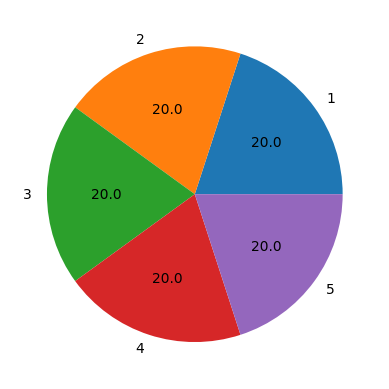

In [ ]:
classes = np.unique(np.array(reviews)[:, 1], return_counts=True)
plt.pie(classes[1], labels=classes[0], autopct='%.1f');

In [ ]:
data_path = f'{dir_path}/data'

# f = open(data_path, 'wb')
# pickle.dump(reviews, f)
# f.close()

f = open(data_path, 'rb')
data = pickle.load(f)
f.close()

In [ ]:
data = np.array(data)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data[:,0])
y = data[:, 1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic regression': LogisticRegression(),
    'Decision tree': DecisionTreeClassifier(),
    'k Nearest Neighbor n=3': KNeighborsClassifier(n_neighbors = 3),
    'k Nearest Neighbor n=5': KNeighborsClassifier(n_neighbors = 5),
    'k Nearest Neighbor n=7': KNeighborsClassifier(n_neighbors = 7),
    'Random forest n=100': RandomForestClassifier(n_estimators= 100),
    'Random forest n=100': RandomForestClassifier(n_estimators= 30),
    'Random forest n=100': RandomForestClassifier(n_estimators= 150),
    'Ridge Classifier': RidgeClassifier()
}

In [ ]:
results = pd.DataFrame(columns=['Модель', 'Время обучения', 'Время тестирования', 'Точность'])


for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train.toarray(), y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test.toarray())
    testing_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)

    results = results.append({'Модель': model_name, 'Время обучения': training_time,
                              'Время тестирования': testing_time, 'Точность': accuracy}, ignore_index=True)

In [ ]:
results

,Модель,Время обучения,Время тестирования,Точность
0,Naive Bayes,5.344018,2.103123,0.3256
1,Logistic regression,100.700284,0.619787,0.5096
2,Decision tree,25.732353,0.776957,0.3416
3,k Nearest Neighbor n=3,1.976829,14.344986,0.3704
4,k Nearest Neighbor n=5,1.507669,13.657672,0.4064
5,k Nearest Neighbor n=7,1.833362,13.999578,0.4176
6,Random forest n=100,44.700500,0.579621,0.4880
7,Ridge Classifier,29.312049,0.521163,0.4984


In [ ]:
model = LogisticRegression()
model.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.51      0.57      0.54       247
           2       0.42      0.33      0.37       257
           3       0.41      0.46      0.44       247
           4       0.51      0.52      0.52       248
           5       0.68      0.68      0.68       251

    accuracy                           0.51      1250
   macro avg       0.51      0.51      0.51      1250
weighted avg       0.51      0.51      0.51      1250



In [ ]:
data[:,1] = np.where(data[:,1] == "1", "Плохо", data[:, 1])
data[:,1] = np.where(data[:,1] == "2", "Плохо", data[:, 1])
data[:,1] = np.where(data[:,1] == "3", "Средне", data[:, 1])
data[:,1] = np.where(data[:,1] == "4", "Средне", data[:, 1])
data[:,1] = np.where(data[:,1] == "5", "Хорошо", data[:, 1])

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data[:,0])
y = data[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

results = pd.DataFrame(columns=['Модель', 'Время обучения', 'Время тестирования', 'Точность'])

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train.toarray(), y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test.toarray())
    testing_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)

    results = results.append({'Модель': model_name, 'Время обучения': training_time,
                              'Время тестирования': testing_time, 'Точность': accuracy}, ignore_index=True)
results

,Модель,Время обучения,Время тестирования,Точность
0,Naive Bayes,3.729455,1.451491,0.5000
1,Logistic regression,55.865222,0.629274,0.6552
2,Decision tree,27.668490,0.513752,0.5328
3,k Nearest Neighbor n=3,1.800034,12.564686,0.5552
4,k Nearest Neighbor n=5,1.826704,13.182719,0.5744
5,k Nearest Neighbor n=7,1.696864,13.353085,0.5888
6,Random forest n=100,42.301058,0.565129,0.6328
7,Ridge Classifier,26.737533,0.428997,0.6608


In [ ]:
model = models['Logistic regression']
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Плохо       0.70      0.71      0.71       504
      Средне       0.57      0.64      0.60       495
      Хорошо       0.79      0.57      0.66       251

    accuracy                           0.66      1250
   macro avg       0.69      0.64      0.66      1250
weighted avg       0.67      0.66      0.66      1250



In [ ]:
rating = []

def parse2(start, end):
  for x in range(start, end):
    url =  f'https://www.banki.ru/services/responses/list/?page={x}&is_countable=on'
    page = requests.get(url)
    content = page.text
    soup = BeautifulSoup(content, "lxml")
    rws = soup.find_all('div', {"class" : "la8a5ef73"})
    for i in range(len(rws) -1):
      rating.append((rws[i].find("img")['alt'], int(rws[i].find("div", {"class": "lb3db10af"}).text)))

thrds = [Thread(target=parse2, args=(2+i*4, 2+ (i+1) * 4)) for i in range(0, 15)]
for thrd in thrds:
  thrd.start()
for thrd in thrds:
  thrd.join()

Exception in thread Thread-75 (parse2):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-25-3ef9e1aa6423>", line 11, in parse2
TypeError: 'NoneType' object is not subscriptable
Exception in thread Thread-64 (parse2):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-25-3ef9e1aa6423>", line 11, in parse2
TypeError: 'NoneType' object is not subscriptable
Exception in thread Thread-72 (parse2):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._targ

In [ ]:
rating_path = f'{dir_path}/rating'

# f = open(rating_path, 'wb')
# pickle.dump(rating, f)
# f.close()

f = open(rating_path, 'rb')
data = pickle.load(f)
f.close()

In [ ]:
df = pd.DataFrame(data, columns=["Банк", "Оценка"])

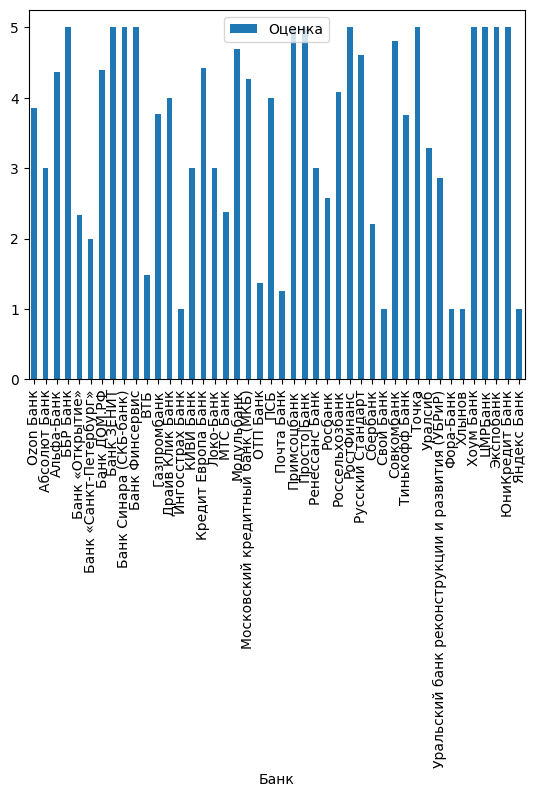

In [ ]:
df.groupby("Банк").mean().plot.bar();

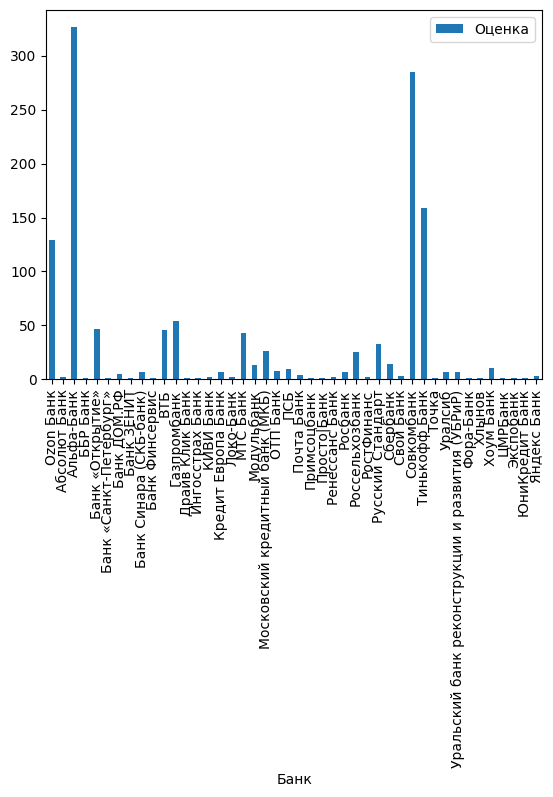

In [ ]:
df.groupby("Банк").count().plot.bar();

# Задание

In [ ]:
f = open(data_path, 'rb')
data = pickle.load(f)
f.close()

In [ ]:
df = pd.DataFrame(data, columns = ["Отзыв", "Оценка"])

In [ ]:
df.head()

,Отзыв,Оценка
0,"\nДобрый день, читатели! в октябре 2023 открыл...",4
1,\n3 декабря оплачивал коммунальные услуги карт...,2
2,"\n\tСегодня проверял расходы и увидел, что 17....",4
3,\nОтвратительная логистика маркетплейса мегама...,4
4,\nЗдравствуйте. 6 декабря 2023 г банкомат втб ...,3


In [ ]:
df["Отзыв"][0]

'\nДобрый день, читатели! в октябре 2023 открыл и пополнил в МТС банке накопительный счет, по условиям договора начисление процентов на остаток производиться не позднее 1-го числа  следующего месяца. Как Вы уже  правильно понимаете, проценты не начислили. Обратился в чат банка, сказали что есть небольшие задержки с начислением и выплатой процентов, ожидайте... В итоге за окном 10.11.2023, а проценты так и не начислили... Обращался к персональному менеджеру (являюсь премиум клиентом), обещали сначала решить вопрос до 06.11.2023, потом сдвинули сроки вправо до 12.11.2023...  Уверен, что банк когда-нибудь проценты таки выплатит, но осадочек остался... Вцелом банком и сервисами доволен, но вот накопительным счетом больше никогда пользоваться не буду, и Вам не рекомендую!\xa0\xa0\n'

In [ ]:
df["Отзыв"] = df.apply(lambda row: row["Отзыв"].replace("\n", '').replace('\xa0', ''), axis = 1)

In [ ]:
rating_map = {
    5: "Пять",
    4: 'Четыре',
    3: "Три",
    2: "Две",
    1: "Одна",
}

# def rating_str(value):
#   if value == 5:
#     return "Пять"
#   elif value == 4:
#     return "Четыре"
#   elif value == 3:
#     return "Три"
#   elif value == 2:
#     return "Два"
#   elif value == 1:
#     return "Единица"
#   else:
#     return "Без оценки"

df["Оценка_str"] = df.apply(lambda row: rating_map.get(row["Оценка"], "Без оценки"), axis = 1)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=df["Оценка_str"].value_counts().index, values=df["Оценка"].value_counts().values,
                             textinfo='label+percent', title='Баланс оценок', insidetextorientation='radial', scalegroup='one')])

fig.update_layout(
    title=dict(text="Баланс оценок", font=dict(size=20), automargin=True, yref='paper')
)

fig.show()

In [ ]:
df["Review"] = df.apply(lambda row: 1 if row["Оценка"] == 5 else 0, axis = 1)
df["Review_str"] = df.apply(lambda row: "Позитивный" if row["Review"] == 1 else "Негативный", axis = 1)

In [ ]:
df.head()

,Отзыв,Оценка,Оценка_str,Review,Review_str
0,"Добрый день, читатели! в октябре 2023 открыл и...",4,Четыре,0,Негативный
1,3 декабря оплачивал коммунальные услуги картой...,2,Две,0,Негативный
2,"\tСегодня проверял расходы и увидел, что 17.10...",4,Четыре,0,Негативный
3,Отвратительная логистика маркетплейса мегамарк...,4,Четыре,0,Негативный
4,Здравствуйте. 6 декабря 2023 г банкомат втб за...,3,Три,0,Негативный


In [ ]:
fig = go.Figure(data=[go.Pie(labels=df["Review_str"].value_counts().index, values=df["Review_str"].value_counts().values,
                             textinfo='label+percent', title='Баланс отзывов', insidetextorientation='radial')])

fig.update_layout(
    title=dict(text="Баланс отзывов", font=dict(size=20), automargin=True, yref='paper')
)
fig.show()

In [ ]:
def train_models(models, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  results = pd.DataFrame(columns=['Модель', 'Время обучения', 'Время тестирования', 'Точность'])

  model_names, train_scores, test_scores = [], [], []

  for model_name, model in models.items():
      start_time = time.time()
      model.fit(X_train.toarray(), y_train)
      training_time = time.time() - start_time

      start_time = time.time()
      y_pred = model.predict(X_test.toarray())
      testing_time = time.time() - start_time

      accuracy = accuracy_score(y_test, y_pred)


      # Оценка на тренировочном наборе
      train_score = model.score(X_train.toarray(), y_train)

      # Оценка на тестовом наборе
      test_score = model.score(X_test.toarray(), y_test)


      model_names.extend([f'{model_name} (train)', f'{model_name} (test)'])
      train_scores.extend([train_score])
      test_scores.extend([test_score])

      results = results.append({'Модель': model_name, 'Время обучения': training_time,
                                'Время тестирования': testing_time, 'Точность': accuracy}, ignore_index=True)

  return results, model_names,train_scores, test_scores

In [ ]:
models = {
    'Наивный байес': GaussianNB(),
    'Логистическая регрессия': LogisticRegression(),
    'Дерево решений': DecisionTreeClassifier(),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'Random Forest (n=30)': RandomForestClassifier(n_estimators=30),
    'Random Forest (n=100)': RandomForestClassifier(n_estimators=100),
}

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Отзыв"])

y = df["Review"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
result, model_names, train_scores, test_scores = train_models(models, X, y)

In [ ]:
result

,Модель,Время обучения,Время тестирования,Точность
0,Наивный байес,12.038063,2.267970,0.8152
1,Логистическая регрессия,10.542907,0.497543,0.8600
2,Дерево решений,61.263100,0.446401,0.8104
3,KNN (k=3),1.037817,17.177200,0.8448
4,KNN (k=5),1.101208,16.501909,0.8544
5,KNN (k=7),1.008599,16.924135,0.8616
6,Random Forest (n=30),14.129795,0.850899,0.8288
7,Random Forest (n=100),39.558805,0.768861,0.8392


In [ ]:
palette = ["green", "blue"]

x = [(i, j) for i in models.keys() for j in ['train', 'test']]
counts = sum(zip(train_scores, test_scores), ()) # like an hstack

source = ColumnDataSource(data = dict(x = x, counts = counts))

p = figure(x_range = FactorRange(*x), width=1600, height = 500, title = "Сравнение коэффециентов моделей регрессии",
           toolbar_location = None, tools = "")

p.vbar(x = 'x', top = 'counts', width = 0.8, source = source,
       fill_color = factor_cmap('x', palette = palette, factors = ['train', 'test'], start = 1, end = 2))

output_notebook()
show(p)

In [ ]:
models_name = ['наивный байес train',
               'наивный байес test',
               'логистическая регрессия train',
               'логистическая регрессия test',
               'дерево решений train',
               'дерево решений test',
               'метод k ближайших соседей 3 train',
               'метод k ближайших соседей 3 test',
               'метод k ближайших соседей 5 train',
               'метод k ближайших соседей 5 test',
               'метод k ближайших соседей 7 train',
               'метод k ближайших соседей 7 test',
               'random forest 30 train',
               'random forest 30 test',
               'random forest 100 train',
               'random forest 100 test',
               ]

colors = ['тренировочная' if c % 2 == 0 else 'тестовая' for c in range(2 * len(models.keys()))]

fig = px.bar(
    x = models_name, y = [item for pair in zip(train_scores, test_scores) for item in pair], color = colors,
    color_discrete_sequence=['green', 'blue'],
    title = 'Сравнение результатов различных моделей'
)
fig.show()

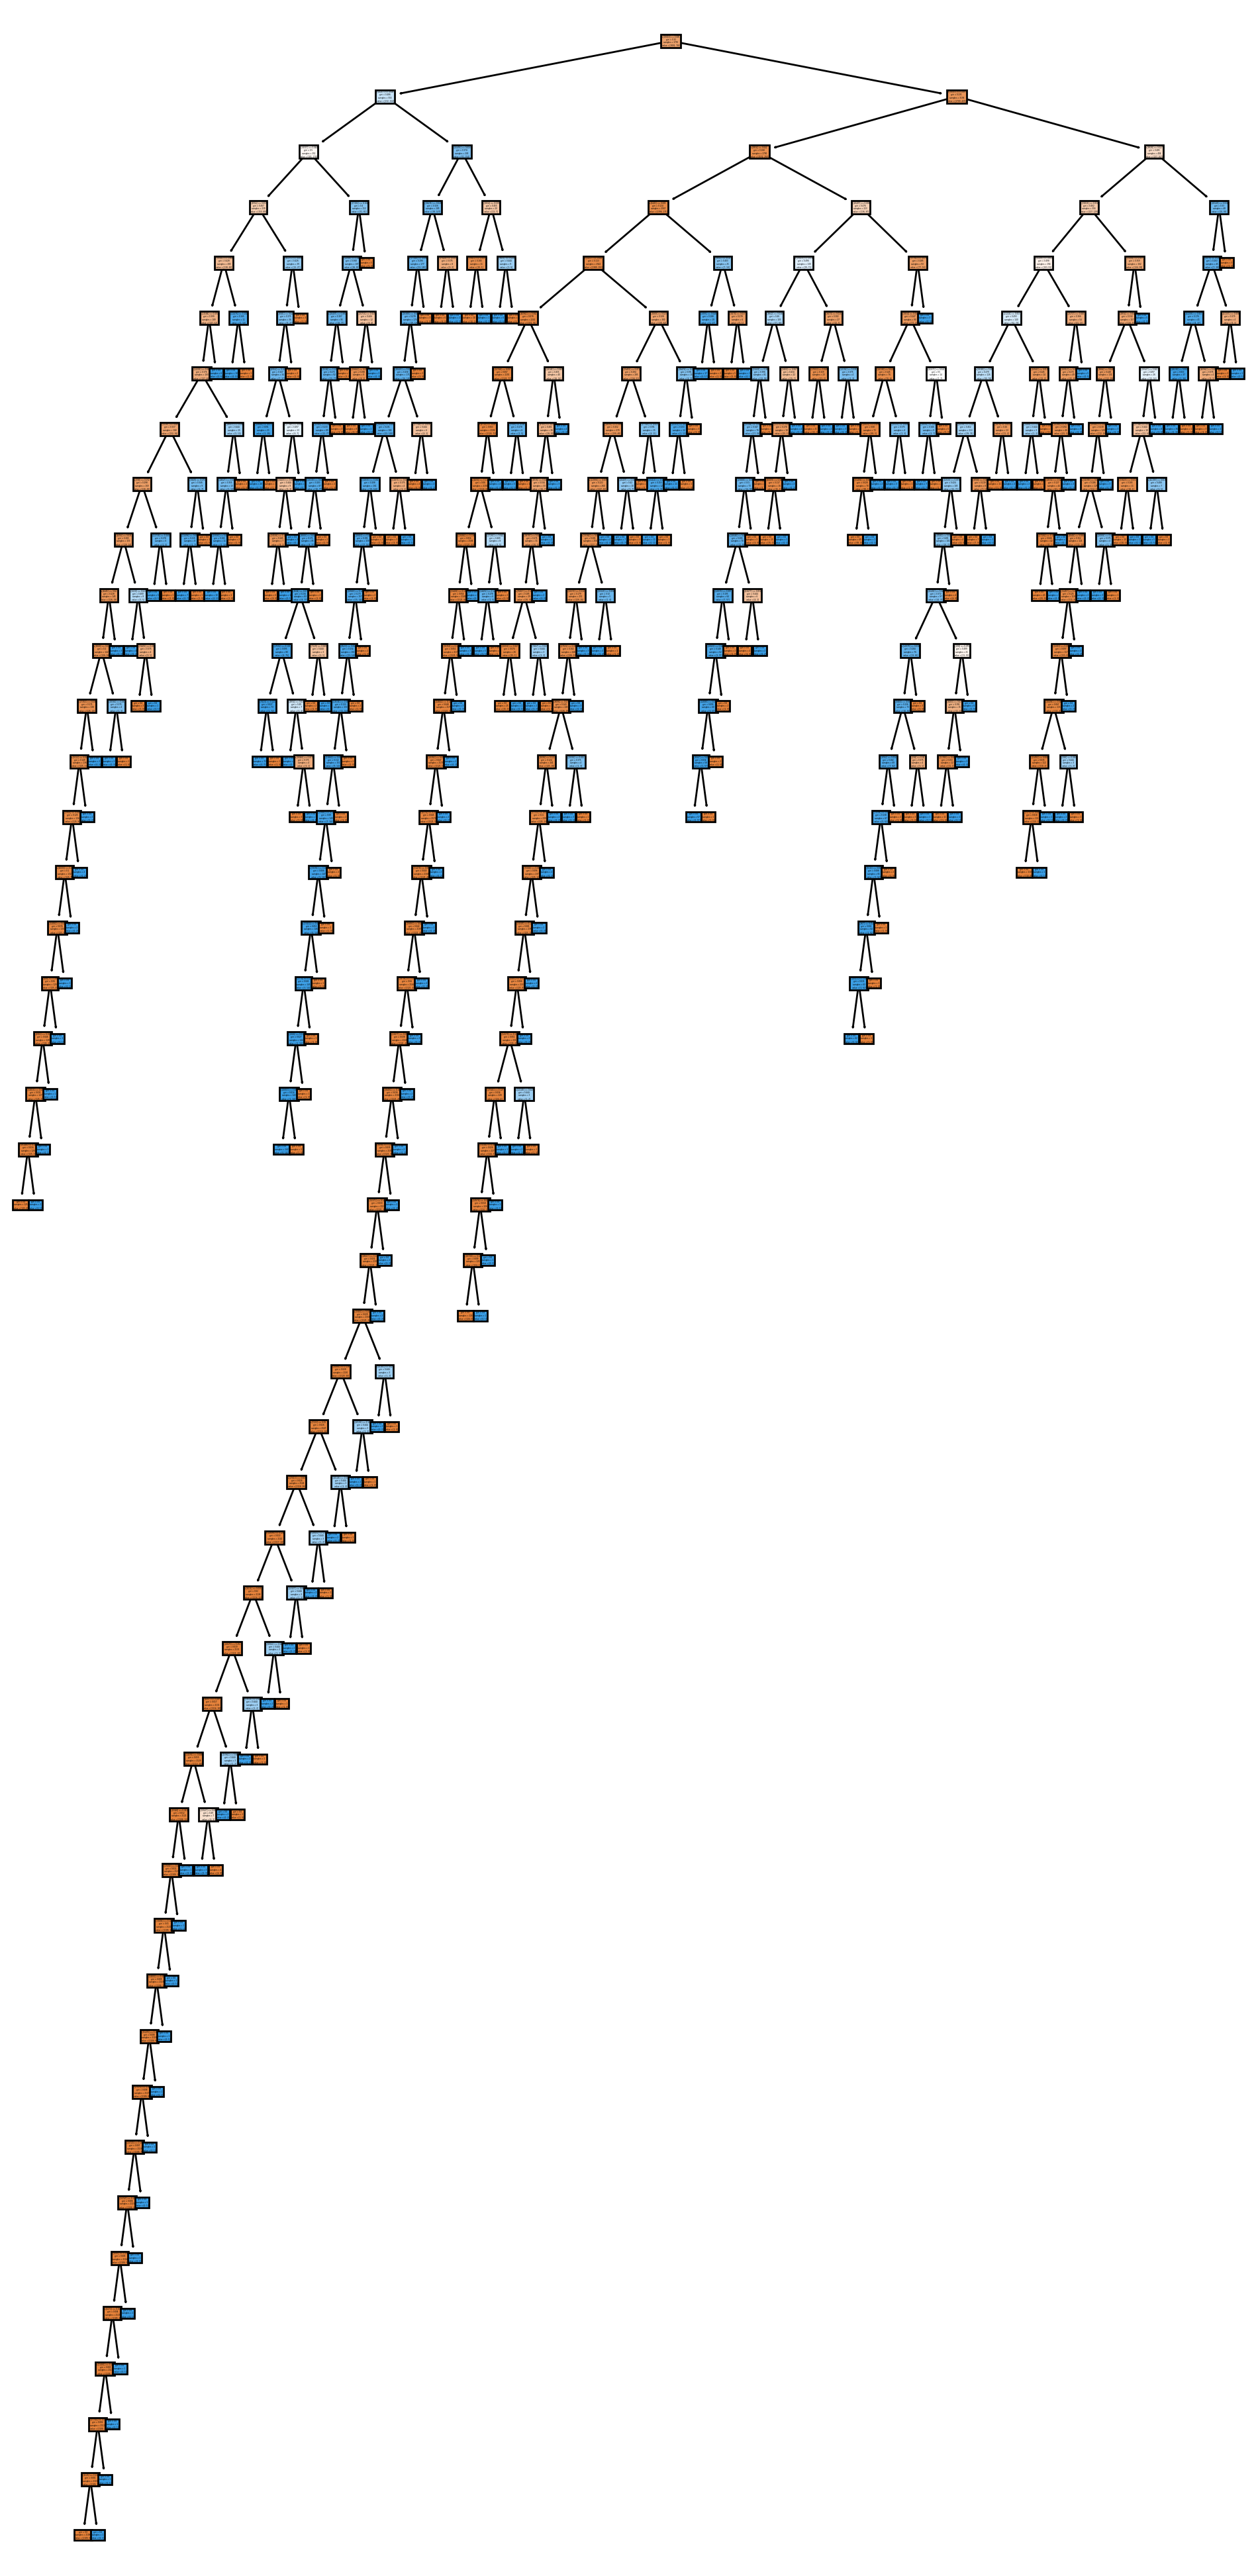

In [ ]:
plt.figure(figsize = (12, 25), dpi = 200)
tree.plot_tree(models['Дерево решений'], filled = True)
plt.show()

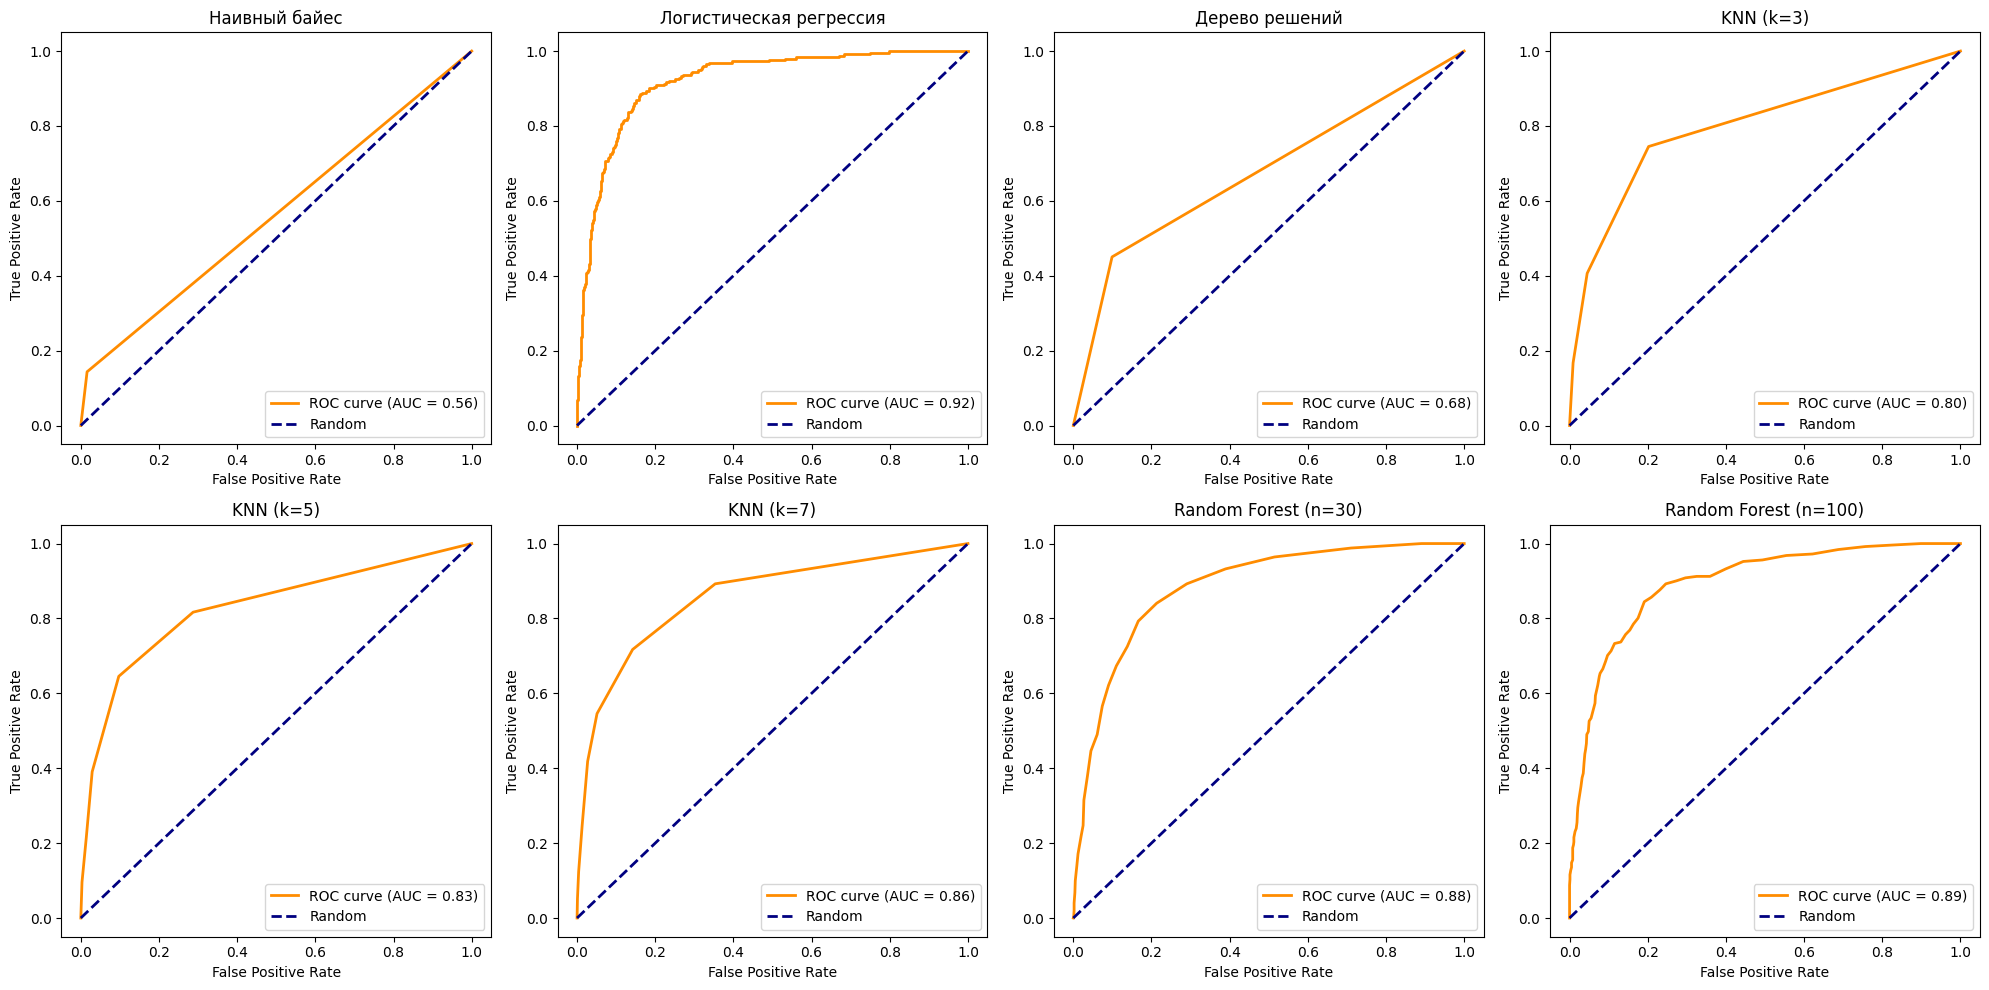

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Создаем сетку из RocAUC графиков
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for (name, model), ax in zip(models.items(), axes):
    # Получаем предсказанные вероятности положительного класса
    y_pred_proba = model.predict_proba(X_test.toarray())[:, 1]

    # Вычисляем ROC-кривую и AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Строим ROC-кривую для текущей модели
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_title(name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

# Регулируем расположение графиков
plt.tight_layout()
plt.show()
